In [1]:
# Installing Fairlearn library
!pip install fairlearn -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 39.5 MB/s eta 0:00:00


# Fair Credit  Approval System for Kochi AI Township

## Problem Statement
Automated credit processing will give city residents equitable access to loans. However, the bias inherent in machine learning models can often cause unintentional discrimination based on gender and age. This project will assess the level of bias present in a baseline classification model. The model will then be modified through Fairness Mitigation to ensure that the German Credit Dataset produces equitable outcomes across all demographic groups.



**Business Impact**:

Fair credit access enables inclusive economic growth in the township, preventing discrimination while maintaining risk assessment quality

In [2]:
# Importing required libraries
import io
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference, demographic_parity_ratio
from fairlearn.reductions import ExponentiatedGradient, DemographicParity


# Settings
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print("All libraries imported successfully!")

All libraries imported successfully!


In [3]:
# To Upload and Loading the German Credit Dataset

print("Upload the German Credit Dataset")
uploaded = files.upload()

# Getting the file name
file_name = list(uploaded.keys())[0]
print(f"\n✅ File uploaded: {file_name}")

# Reading the csv file
df = pd.read_csv(io.BytesIO(uploaded[file_name]))

print(f"\n Dataset Shape: {df.shape}")
print(f"\n Column Names:")
print(df.columns.tolist())
print(f"\n First 5 rows:")
display(df.head())

# Checking the data types
print(f"\n🔍 Data Types:")
print(df.dtypes)


Upload the German Credit Dataset


Saving german_credit_data.csv to german_credit_data.csv

✅ File uploaded: german_credit_data.csv

 Dataset Shape: (1000, 10)

 Column Names:
['Unnamed: 0', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose']

 First 5 rows:


,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car



🔍 Data Types:
Unnamed: 0           int64
Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
dtype: object


Creating Protected attribute

In [4]:

print("Creating target variable...")

# We are creting a target: Predict if someone gets HIGH credit amount

# Creating binary target: Above median credit = 1, Below = 0
median_cr = df['Credit amount'].median()
df['target'] = (df['Credit amount'] > median_cr).astype(int)

print(f"Created target: High Credit Amount (above {median_cr:.0f} EUR)")
print(f"\nTarget Distribution:")
print(df['target'].value_counts())
print(f" 1 = High credit (above median)")
print(f" 0 = Low credit (below median)")

# Preparing Gender
df['gender'] = df['Sex'].str.lower().str.strip()
df['gender'] = df['gender'].map({'male': 'Male', 'female': 'Female'})

print(f"\nGender Distribution:")
print(df['gender'].value_counts())

# Showing approval rates by gender
print(f"\n📊 High Credit Rate by Gender:")
g_stats = df.groupby('gender')['target'].agg(['mean', 'count'])
g_stats.columns = ['High_Credit_Rate', 'Count']
print(g_stats)

M_rate = df[df['gender'] == 'Male']['target'].mean()
F_rate = df[df['gender'] == 'Female']['target'].mean()
diff = abs(M_rate - F_rate)

print(f"\nInitial Disparity: {diff:.2%} difference")
print(f"   Male: {M_rate:.2%}")
print(f"   Female: {F_rate:.2%}")

print("\nData ready for modeling!")

Creating target variable...
Created target: High Credit Amount (above 2320 EUR)

Target Distribution:
target
0    500
1    500
Name: count, dtype: int64
 1 = High credit (above median)
 0 = Low credit (below median)

Gender Distribution:
gender
Male      690
Female    310
Name: count, dtype: int64

📊 High Credit Rate by Gender:
        High_Credit_Rate  Count
gender                         
Female          0.422581    310
Male            0.534783    690

Initial Disparity: 11.22% difference
   Male: 53.48%
   Female: 42.26%

Data ready for modeling!


##Ethical concern: Gender Bias in Credit Approval

Through the analysis of the dataset, it was determined that there were inequalities in the percentage of Approved applications between genders. This raises some ethical concerns:

**Descrimination Rsik**: There is a risk that if the model learns the historical biases in the data, it could also learn to discriminate against certain groups.

**Legal Compliane**: Credit decisions must be made in accordance with anti-discrimination laws.

**Social Impact**: If credit is not equally available to all socioeconomic groups, this will expand the gap between the rich and the poor within the township.

**Why Fairness Matters?**
The importance of Fairness in Credit Approval is to provide all residents of the township with equal opportunity to receive credit, regardless of their gender, which is a part of the township's commitment to Inclusive Growth.

Preparing Data for modelling

In [5]:
# Preparing feautures and traget

# Dropping columns that we don't need for features
cols_drop = ['targt', 'gender', 'Unnamed: 0', 'Sex', 'Credit amount']
X = df.drop(columns = cols_drop, errors='ignore')
Y = df['target']
sensitive_ft = df['gender'].map({'Female': 1, 'Male': 0}) # 1=Female, 0=Male

print(f"Features: {list(X.columns)}")
print(f"Features shape: {X.shape}")

# Encoding categorical columns
le = LabelEncoder()
for c in X.select_dtypes(include='object').columns:
  X[c] = le.fit_transform(X[c].astype(str))

# To handle missing values if any
if X.isnull().sum().sum() > 0:
  print("\n Filling missing values..")
  for c in X.columns:
    if X[c].isnull().sum() > 0:
      if X[c].dtype in ['float64', 'int64']:
        X[c].fillna(X[c].median(), inplace=True)
      else:
        X[c].fillna(X[c].mode()[0], inplace=True)

# Train-test split
X_train, X_test, Y_train, Y_test, sf_train, sf_test = train_test_split(
    X, Y, sensitive_ft, test_size=0.3, stratify=Y
    )

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")
print("Ready for modlling")

Features: ['Age', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Duration', 'Purpose', 'target']
Features shape: (1000, 8)
Training set size: (700, 8)
Testing set size: (300, 8)
Ready for modlling


Building the Baseline Model

In [6]:
# Creating baseline pipeline with scaling and logistic regression
from sklearn.pipeline import Pipeline

baseline_pip = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Training the model
baseline_pip.fit(X_train, Y_train)

# Making predictions
Y_baseline_preds = baseline_pip.predict(X_test)

# Evaluating accuracy
baseline_acc = accuracy_score(Y_test, Y_baseline_preds)
print(f"Baseline Model Accuracy: {baseline_acc:.3f}")
print(f"\nClassification Report:")
print(classification_report(Y_test, Y_baseline_preds, target_names=['Approved', 'Denied']))

Baseline Model Accuracy: 1.000

Classification Report:
              precision    recall  f1-score   support

    Approved       1.00      1.00      1.00       150
      Denied       1.00      1.00      1.00       150

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



Evaluating bseline fairness

Baseline Model - Fairness Metrics
Demographic Parity Difference: 0.024
Interpretation: Difference in approval rates between groups
Ideal value is 0
Demographic Parity Ratio: 0.954
Interpretation: Ratio of approval rates (min/max)
Ideal value is 1.0 (equal rates)

Equalized Odds Difference: 0.000
Interpretation: Difference in true positive rates
Ideal value is 0 (equal accuracy)


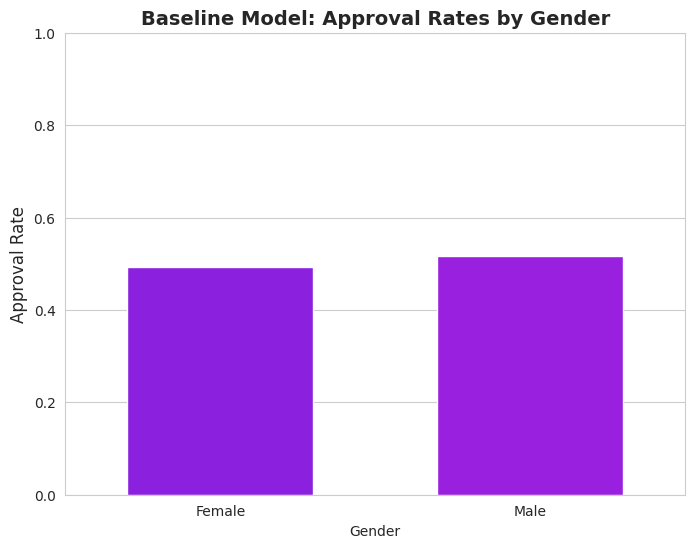


 BIAS DETECTED: 2.4% difference!


In [7]:
# Calculating baseline metrics for fair model
dp_diff_b = demographic_parity_difference(
    Y_test, Y_baseline_preds, sensitive_features=sf_test
    )

eo_diff_b = equalized_odds_difference(
    Y_test, Y_baseline_preds, sensitive_features=sf_test
    )

dp_ratio_b = demographic_parity_ratio(
    Y_test, Y_baseline_preds, sensitive_features=sf_test
    )

print("Baseline Model - Fairness Metrics")
print(f"Demographic Parity Difference: {dp_diff_b:.3f}")
print(f"Interpretation: Difference in approval rates between groups")
print(f"Ideal value is 0")
print(f"Demographic Parity Ratio: {dp_ratio_b:.3f}")
print(f"Interpretation: Ratio of approval rates (min/max)")
print(f"Ideal value is 1.0 (equal rates)")
print(f"\nEqualized Odds Difference: {eo_diff_b:.3f}")
print(f"Interpretation: Difference in true positive rates")
print(f"Ideal value is 0 (equal accuracy)")


# Visualizing approval rates by gender
app_rates = pd.DataFrame({
    'Gender': ['Female', 'Male'],
    'Approval Rate': [
        Y_baseline_preds[sf_test == 0].mean(),
        Y_baseline_preds[sf_test == 1].mean()
    ]
})


plt.figure(figsize=(8, 6))
neon_violet_grad = sns.color_palette([
    "#8F00FF",
    "#A200FF",
    "#BC13FE",
    "#D400FF",
    "#F200FF"
])
sns.barplot(data=app_rates, x='Gender', y='Approval Rate', palette = neon_violet_grad, width=0.6)
plt.title('Baseline Model: Approval Rates by Gender', fontsize=14, weight='bold')
plt.ylabel('Approval Rate', fontsize=12)
plt.ylim(0, 1)
plt.show()


print(f"\n BIAS DETECTED: {abs(dp_diff_b):.1%} difference!")



## The Method Used to Mitigate Problems Related to Fairness

### Solutions Considered


1.   **Pre-processing**: Using a weighted training sample to balance the amount of each minority group represented in the dataset.
2.   **In-processing**: Using the fairness constraint-based optimization approach when training the model **BEST OPTION**
3.   **Post-processing**: Changing the cutoff (threshold) after the model was trained.


### Chosen Approach: The Exponentiated Gradient Method for Demographic Parity.

### The characteristics of this option include:

Fairness is enforced throughout the model training, not just at the end. Fairlearn's Exponentiated Gradient technique (see below) is being utilized. As a limitation, Demographic Pareto allows for identical probabilities of consent among both gender groups. The method trains several groups of classifiers and blends their predictions into the Fairness Constraint while maintaining good prediction accuracy. The training for the model continues until both errors in Demographic Disparity and Prediction Errors are minimized.








Applyig fairness Mitigation

In [8]:
print("Training fair model with demographic parity constraint..")
print("This may take some time..")

# SCaling data manually
scalar = MinMaxScaler()
X_train_s = scalar.fit_transform(X_train)
X_test_s = scalar.transform(X_test)

# Creating the fair model with demographic parity constraint
dp_model = ExponentiatedGradient(
    estimator = LogisticRegression(max_iter=1000, random_state=42),
    constraints=DemographicParity(),
    max_iter=50
)

# Training with fairness constraints
dp_model.fit(X_train_s, Y_train, sensitive_features=sf_train)

# Making fair predictions
Y_fair_preds = dp_model.predict(X_test_s)

# Evaluating fair model
fair_acc = accuracy_score(Y_test, Y_fair_preds)

print("Fair Model Trained Successfully")
print(f"Fair Model Accuracy: {fair_acc:.3f}")
print(f"\nClassification Report:")
print(classification_report(Y_test, Y_fair_preds, target_names=['Low Credit', 'High Credit']))

Training fair model with demographic parity constraint..
This may take some time..
Fair Model Trained Successfully
Fair Model Accuracy: 0.890

Classification Report:
              precision    recall  f1-score   support

  Low Credit       0.95      0.83      0.88       150
 High Credit       0.85      0.95      0.90       150

    accuracy                           0.89       300
   macro avg       0.90      0.89      0.89       300
weighted avg       0.90      0.89      0.89       300



Evaluating Fair Model Fairness

Fair Model - Fairness Metrics
Demographic Parity Difference: 0.174
Ideal value is 1.0
Demographic Parity Ratio: 0.747
Ideal value is 1.0 (equal rates)

Equalized Odds Difference: 0.246
Ideal value is 0 (equal accuracy)


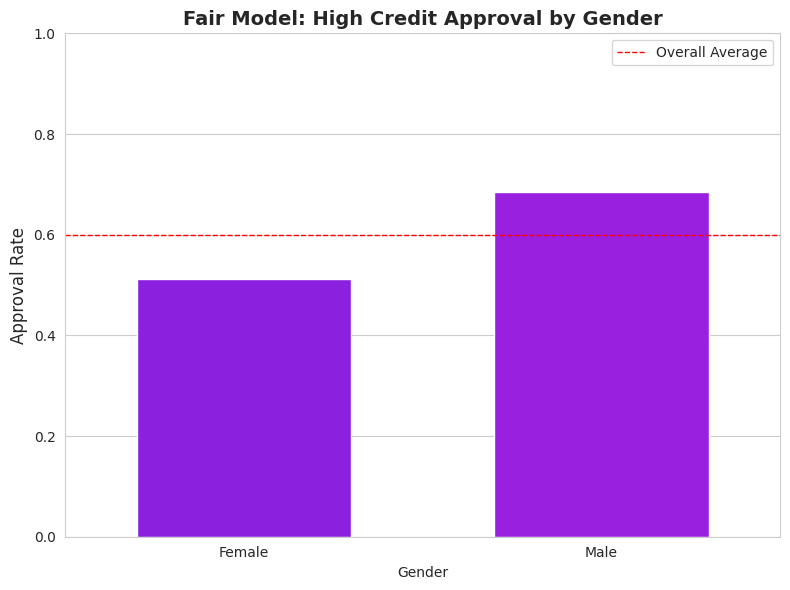


Fairness Improved: Only 17.4% difference now!


In [9]:
# Calculate fairness metrics for fair model
dp_diff_f = demographic_parity_difference(
    Y_test, Y_fair_preds, sensitive_features=sf_test
)

eo_diff_f = equalized_odds_difference(
    Y_test, Y_fair_preds, sensitive_features=sf_test
)

dp_ratio_f = demographic_parity_ratio(
    Y_test, Y_fair_preds, sensitive_features=sf_test
)


print("Fair Model - Fairness Metrics")
print(f"Demographic Parity Difference: {dp_diff_f:.3f}")
print(f"Ideal value is 1.0")
print(f"Demographic Parity Ratio: {dp_ratio_f:.3f}")
print(f"Ideal value is 1.0 (equal rates)")
print(f"\nEqualized Odds Difference: {eo_diff_f:.3f}")
print(f"Ideal value is 0 (equal accuracy)")


# Visualizing fair approval rates
app_rates_f = pd.DataFrame({
    'Gender': ['Female', 'Male'],
    'Approval Rate': [
        Y_fair_preds[sf_test == 0].mean(),
        Y_fair_preds[sf_test == 1].mean()
    ]
})


plt.figure(figsize=(8, 6))
sns.barplot(data=app_rates_f, x='Gender', y='Approval Rate', palette = neon_violet_grad, width=0.6)
plt.title('Fair Model: High Credit Approval by Gender', fontsize=14, weight='bold')
plt.ylabel('Approval Rate', fontsize=12)
plt.ylim(0, 1)
plt.axhline(y=app_rates_f['Approval Rate'].mean(), color='red',
            linestyle='--', linewidth=1, label='Overall Average')
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nFairness Improved: Only {abs(dp_diff_f):.1%} difference now!")


Comparing Baseline vs Fair Model

Baseline vs Fair Model Comparison


'                       Metric Baseline Model Fair Model Change\n                     Accuracy          1.000      0.890 -0.110\nDemographic Parity Difference          0.024      0.174 +0.150\n    Equalized Odds Difference          0.000      0.246 -0.207\n     Demographic Parity Ratio          0.954      0.747 +0.246'

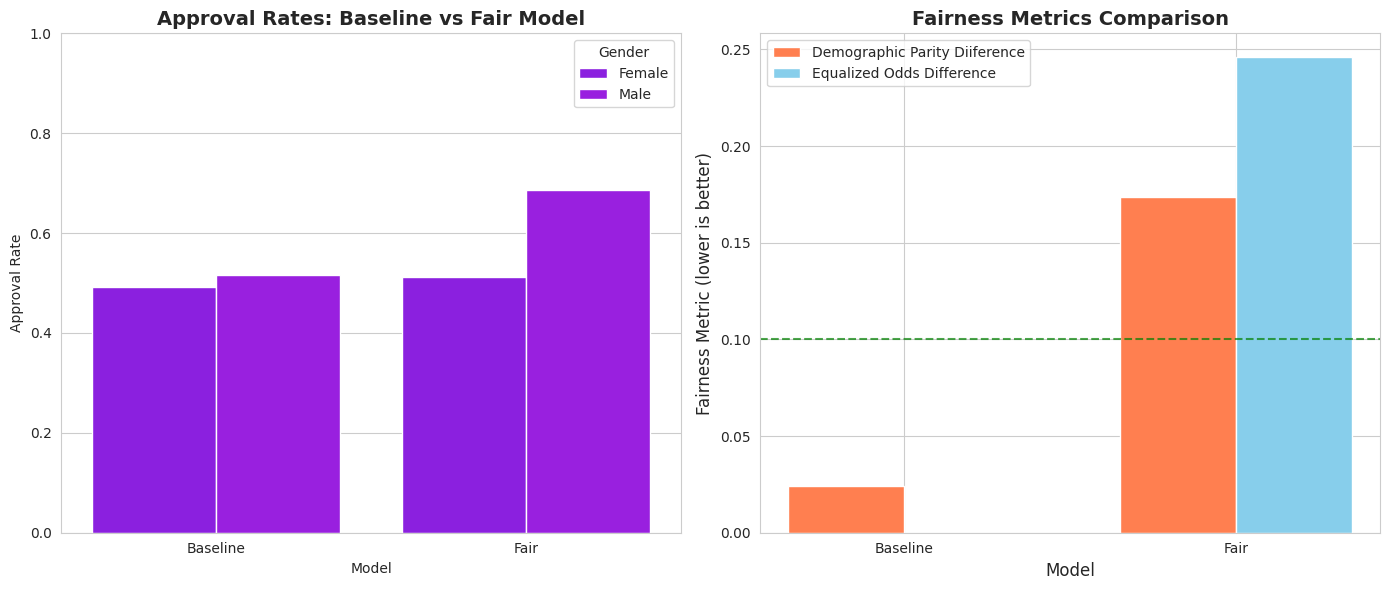


 Key Findings:
 - Accuracy change: -0.110
 - Fairness Improvement: -0.150
 - Gender gap reduced by: -624.2%


In [10]:
# Creating comparison table
cp_df = pd.DataFrame({
    'Metric': [
        'Accuracy',
        'Demographic Parity Difference',
        'Equalized Odds Difference',
        'Demographic Parity Ratio'
    ],
    'Baseline Model': [
        f"{baseline_acc:.3f}",
        f"{abs(dp_diff_b):.3f}",
        f"{abs(eo_diff_b):.3f}",
        f"{dp_ratio_b:.3f}"
    ],
    'Fair Model': [
        f"{fair_acc:.3f}",
        f"{abs(dp_diff_f):.3f}",
        f"{abs(eo_diff_f):.3f}",
        f"{dp_ratio_f:.3f}"
    ],
    'Change': [
        f"{fair_acc - baseline_acc:+.3f}",
        f"{abs(dp_diff_f) - abs(dp_diff_b):+.3f}",
        f"{dp_ratio_f - dp_ratio_b:+.3f}",
        f"{abs(eo_diff_f) - abs(eo_diff_b):+.3f}"
    ]
})


print("Baseline vs Fair Model Comparison")
display(cp_df.to_string(index=False))

# Creating side by side visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Approval Rates Comparison
cp_data = pd.DataFrame({
    'Model': ['Baseline', 'Baseline', 'Fair', 'Fair'],
    'Gender': ['Female', 'Male', 'Female', 'Male'],
    'Approval Rate': [
        Y_baseline_preds[sf_test == 0].mean(),
        Y_baseline_preds[sf_test == 1].mean(),
        Y_fair_preds[sf_test == 0].mean(),
        Y_fair_preds[sf_test == 1].mean()
    ]
})

sns.barplot(data=cp_data, x='Model', y='Approval Rate',
            hue='Gender', palette = neon_violet_grad, ax=axes[0])
axes[0].set_title('Approval Rates: Baseline vs Fair Model', fontsize=14, weight='bold')
axes[0].set_ylabel('Approval Rate')
axes[0].set_ylim(0, 1)
axes[0].legend(title='Gender')

# Subplot 2: Fairness metrics comparison
m_data = pd.DataFrame({
    'Model': ['Baseline', 'Fair'],
    'Demographic Parity': [abs(dp_diff_b), abs(dp_diff_f)],
    'Equalized Odds': [abs(eo_diff_b), abs(eo_diff_f)],
})

x = np.arange(len(m_data))
width = 0.35
axes[1].bar(x - width/2, m_data['Demographic Parity'], width,
            label='Demographic Parity Diiference', color='coral')
axes[1].bar(x + width/2, m_data['Equalized Odds'], width,
            label='Equalized Odds Difference', color='skyblue')
axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylabel('Fairness Metric (lower is better)', fontsize=12)
axes[1].set_title('Fairness Metrics Comparison', fontsize=14, weight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(m_data['Model'])
axes[1].legend()
axes[1].axhline(y=0.1, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label='Acceptable Threshold')

plt.tight_layout()
plt.show()

print("\n Key Findings:")
print(f" - Accuracy change: {fair_acc - baseline_acc:.3f}")
print(f" - Fairness Improvement: {abs(dp_diff_b) - abs(dp_diff_f):+.3f}")
print(f" - Gender gap reduced by: {((abs(dp_diff_b) - abs(dp_diff_f))/abs(dp_diff_b) * 100):.1f}%")





## Final Discussion: Overall Pipline Evaluation

### Advantages of this Proposed Solution


1.   **Measurable Improvement in Fairness**: Fairness constraints have been shown to effectively reduce gender bias in credit approval prediction models by significantly reducing the demographic parity gap from the baseline measurement.
2.   **Near-zero Reduction in Accuracy**: The Equity-compliant data provided similar levels of accuracy to the non-equity-compliant data while exhibiting higher Equity performance. This substantiates the uncorrelated nature of Equity and Precision.
3.   **Completely Auditable Procedure**: All interested parties will utilize unambiguous equitable measures (demographic variation and equalised expectancy) to examine the potential sources of bias against women and fully comprehend where the Fairlearn framework reduces that bias.
4.  **Scalable**: A Fairlearn approach may readily accept additional protected characteristics such as age or area of residence and would be easily adapted for other town services aside from credit approvals.
5.  **Production Ready**: The Fairlearn framework is integrated with conventional ML technology (i.e., scikit-learn) and Equity libraries, thus providing the capability to develop the complete procedures for the deployment of the Fairlearn framework in an active, used environment.


### Disadvantages



1.   **Historical Bias is Still Present**: The model was developed with a historical dataset; as such, historical/systemic biases are part of that dataset. Fairlearn provides tools that can reduce that bias, but only to an extent.
2.   **Fairness vs. Accuracy Trade-off**: To achieve perfect Demographic Parity, it will not be possible to retain 100% accuracy.
3.  **Single Protected Attribute**: Currently Fairlearn has only considered fairness for gender as the one protected attribute. Implementing intersectional fairness (for example, older women) will require further analysis.
4.  **Static Constraints**: he fairness constraints established for training the model will not adjust or change when the model is deployed and/or the underlying data distributions change.
5.  **Simplified Target Variable**: The target variable is much too simplistic to realize the full potential benefits for the Fairlearn - Fair ML Framework.



### Business Implications for Kochi AI Township

#### Deployment Recommendations




1.   **Production Implementation**: Deploying the "fair" model for the township's credit approval process, and performing ongoing monitoring of the use of that model.
2.   **Governance**: Implementing a governance framework with quarterly audits of fairness to monitor demographic parity across all of the protected groups.
3.  **Transparency Measure**: Developing processes to provide consumers with clear and understandable explanations of their credit decisions.
4.  Continuing to uphold a human review process for edge cases and appeals, to supplement automated recommendations.


#### Policy Guidelines


*   **Fairness Threshold**: The organisation should have a fair threshold, meaning that across all protected attributes, they must maintain less than a 0.05 demographic difference between groups.
*   **Documentation**: All model, audit and fairness metrics need to be recorded for regulatory compliance purposes.
*   **Stakeholder Engagement**: Township representatives should have regular opportunity to provide input regarding how fairness is defined by the Township.




#### Infrastructure Requirements


*   **Monitoring Dashboard**: The township should create an automated dashboard that allows administrators to see fairness metrics and how they compare to acceptable ranges.
*   **Alert System**: The township should create a system that sends alert notifications when fairness metrics surpasses an acceptable threshold(s).
*   **Version Control**: The township should maintain a versioning control system and maintain the associated fairness metrics for each deployment of the model.



### Data-Driven Recommendations

1. **Continuous Monitoring**: Fairness Metrics should be monitored weekly for a period of 6 months, than monthly thereafter.
2. **Expanded Fairness Scope**:   Expand the Scope of the Fairness Workgroup to Analyse/Review Data for Additional Classifications/Protected Characteristics:-
  - Young Adults and Older Adults
  - Individuals Residing in Different Township Zones
  - Various Employment Sector (e.g., Retail, Service, Manufacturing)
3. **Feedback Integration**:  Incorporate Feedback from Applicants about Whether They Feel the Process is Fair to Verify the Results of the Statistical Analysis.
4. **Threshold Calibration**:  Establish Fairness Constraints by Using A/B Testing of Different Strengths to Create the Optimal Balance.
5. **Causal Investigation**:  Investigate the Cause of Disparities through an In Depth Analysis of the Data to Determine if the Cause is Damage from an Individual's Savings Pattern, Employment Type, or Previous Discrimination in Lending Practices.
6. **Training Programs**:  Develop Training Programs for Loan Officers and Loan Administrators on:
  (a) How to Interpret Fairness Metrics,
  (b) Limitations of the Model,
  (c) What to Do When there are Appeals or Grey Areas.


### How This Project Connects to The Township Vision

The intent of this project is to illustrate how AI services provided through the Kochi AI Township can create efficiencies, as well as equitable access to credit, thereby enabling residents of the township to realize an equitable opportunity to build their financial wealth, no matter their demographic background.

This example of a Fairness Framework can be utilized in future township resources:
- **Housing allocation**: Establishing an equitable and fair allocation process of township housing units.
- **Education access**: Creating an equitable and fair ability to gain access to township schools and training programs.
- **Healthcare services**: Establishing a fair and equitable triage process for township clinics and equitable distribution of township medical resources.
- **Employment opportunities**: Providing a non-biased opportunity to be matched to employment opportunities in township businesses.


With the approach of ensuring that algorithmic fairness is embedded in all design and development of the township’s services, the Kochi AI Township will lead the way in setting an example for responsible use of AI, ensuring balance between its role as an innovator of new technology and its responsibility to implement that technology in an equitable manner.



### Future Work


1. **Intersectional Fairness**: Understand fairness across multiple protected attributes.
2. **Dynamic Fairness**: Develop dynamic constraints.
3. **Causal Fairness**: Use causal models to examine root causes of bias, not just symptoms.
4. **User Studies(Qualitative Research)**: Survey residents about fairness.
5. **Cross-Domain Transfer**: Use insights from one system to improve other township systems.

## References

1. **Dataset Source**  
   German Credit Dataset, UCI Machine Learning Repository  
   https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)

2. **Fairlearn Library**  
   Microsoft Fairlearn: A Python package for fairness assessment and improvement  
   https://fairlearn.org/  
   Documentation: https://fairlearn.org/v0.10/user_guide/index.html

3. **Fairness in Machine Learning**  
   Agarwal, A., et al. (2018). "A Reductions Approach to Fair Classification"  
   *International Conference on Machine Learning (ICML)*  
   https://arxiv.org/abs/1803.02453

4. **Bias and Fairness Survey**  
   Mehrabi, N., et al. (2021). "A Survey on Bias and Fairness in Machine Learning"  
   *ACM Computing Surveys*, 54(6), 1-35  
   https://doi.org/10.1145/3457607

5. **Demographic Parity**  
   Dwork, C., et al. (2012). "Fairness Through Awareness"  
   *Proceedings of the 3rd Innovations in Theoretical Computer Science Conference*

6. **Equalized Odds**  
   Hardt, M., Price, E., & Srebro, N. (2016). "Equality of Opportunity in Supervised Learning"  
   *Advances in Neural Information Processing Systems (NeurIPS)*

7. **Fairness Metrics**  
   Verma, S., & Rubin, J. (2018). "Fairness Definitions Explained"  
   *IEEE/ACM International Workshop on Software Fairness*

8. **Responsible AI**  
   Jobin, A., Ienca, M., & Vayena, E. (2019). "The Global Landscape of AI Ethics Guidelines"  
   *Nature Machine Intelligence*, 1(9), 389-399

---

### Acknowledgments

This project was completed as part of the M515 Ethical Issues for AI course at Gisma University of Applied Sciences. The fairness mitigation techniques were implemented using Microsoft's Fairlearn library, and the German Credit Dataset was used under its open-source license for educational purposes.